In [16]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Use `cv2.COLOR_RGB2GRAY` if you've read in an image using `mpimg.imread()`. Use `cv2.COLOR_BGR2GRAY` if you've read in an image using `cv2.imread()`.

### Pipeline Steps:

1. Calibrate the incoming image to correct for camera distortion
1. Distort to bird's eye view
    1. Find the lane lines
    1. Find the closest and farthest points on each lane line
    1. Transform those points to be rectangular(?)
1. Use Sobel operator to detect roughly vertical lines?

In [17]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Grayscale
    # Apply cv2.Sobel()
    # Take the absolute value of the output from cv2.Sobel()
    # Scale the result to an 8-bit range (0-255)
    # Apply lower and upper thresholds
    # Create binary_output
    return binary_output

In [18]:
def birds_eye(img):
    img_size = img.shape[0]
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pdb
from pathlib import Path

## Camera Calibration Step

In [37]:
PATH = Path('./camera_cal/')
n_cols = 9
n_rows = 6
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

objp = np.zeros((n_cols*n_rows,3), np.float32)
objp[:,:2] = np.mgrid[0:n_cols,0:n_rows].T.reshape(-1,2)

In [42]:
for filename in list(PATH.iterdir()):
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (n_cols, n_rows), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (n_cols, n_rows), corners, ret)
    else: 
        print('Unable to calibrate using', filename)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Unable to calibrate using camera_cal\calibration1.jpg
Unable to calibrate using camera_cal\calibration4.jpg
Unable to calibrate using camera_cal\calibration5.jpg


Let's grab a warped looking file and run it through the calibration step...

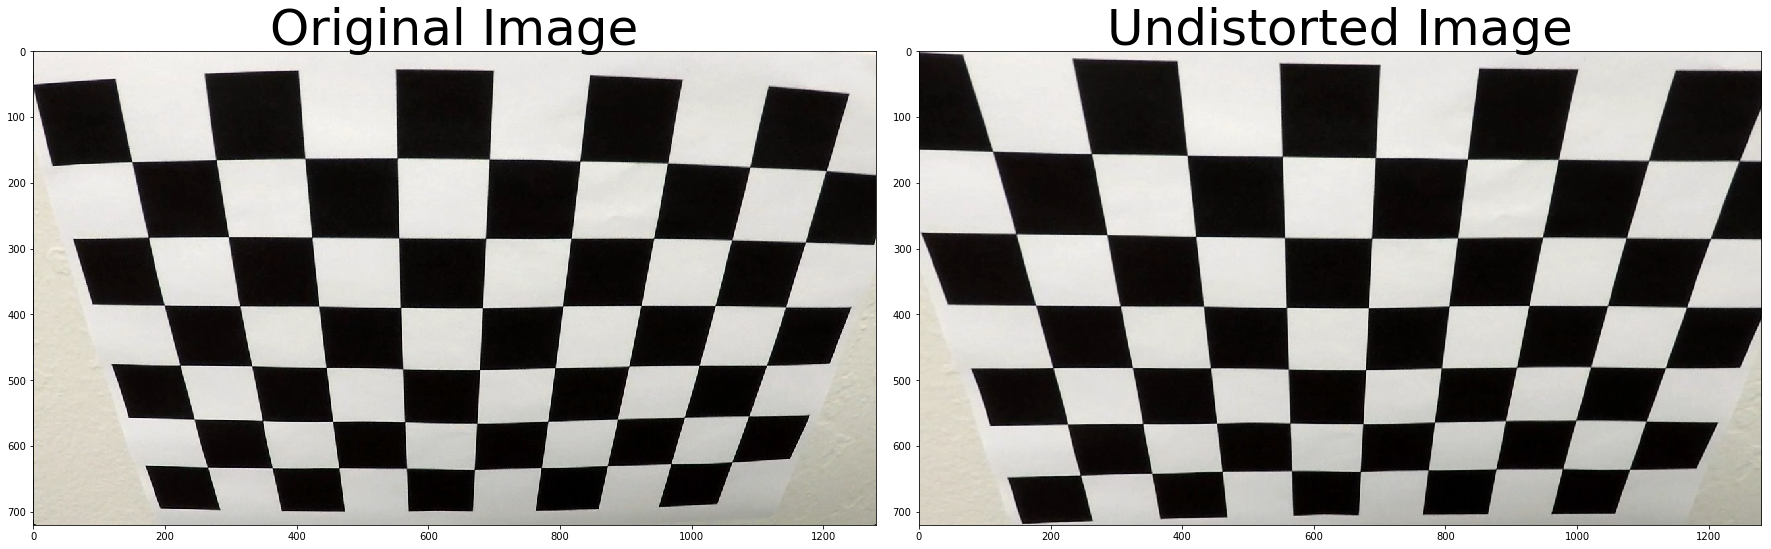

In [44]:
filename = list(PATH.iterdir())[11]
img = plt.imread(filename)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Let's take a look at some of the test images

This code is very handy for displaying a few images easily

8


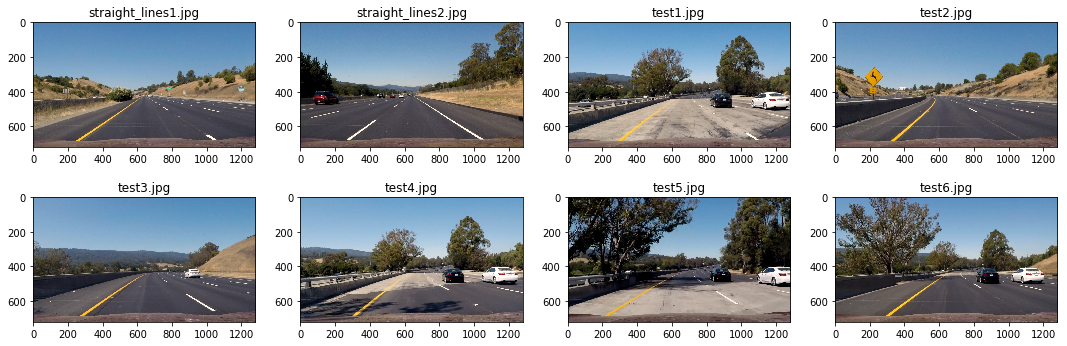

In [52]:
PATH = Path('./test_images/')
n_images = len(list(PATH.iterdir()))
print(n_images)
row_len = 4

fig,axes=plt.subplots(n_images//row_len, row_len, figsize=(15,5))
for i, ax in enumerate(axes.flat):
    filename = list(PATH.iterdir())[i]
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
    ax.imshow(img)
    ax.set_title(str(filename).split('\\')[-1])
plt.tight_layout()

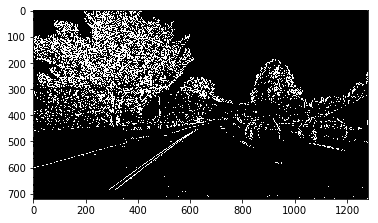

In [65]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(gray, cmap='gray')

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobelx)
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')
# plt.imshow(scaled_sobel)